# **Optimize Data Science Models with Feature Engineering  **
## Cluster Analysis, Metrics Development, and PCA with Baby Name Trends Data

This is a companion notebook to blog article (on medium and personal site) with public USA dataset and executeable code. Please view the article for detailed write up and description of the code. The dataset is provided through Google BigQuery. 

**Notebook Sections**
1. Loading Python Libraries 
2. Loading and Converting Data into CSV
3. Summarize Data (recommend [Salil Gautam's A Very Extensive Exploratory Analysis Notebook]
(https://www.kaggle.com/salil007/a-very-extensive-exploratory-analysis-usa-names) for visualizations and summary statistics)
4. Clustering based on metrics (manually created features) 

    a. Setting the criteria for baby names & create the features from the dataset
     - peak detection algorithm features
     - top 500 list 
     - year over year growth
     
    b. Combine features into one dataframe
    
    c. Kmeans clustering on dataframe with new features
    
    d. Output list of baby names from selected cluster 
    
5. Clustering based on PCA (automatically created features) 

    a. Perform principle component analysis on baby name trends
    
    b. Kmeans clustering on dataframe with pca features
    
    d. Output list of baby names from selected cluster 
    
6. Compare lists from (4) and (5)

### (1) **Loading Python Libraries**

In [1]:
#Load necessary libraries for code
import numpy as np 
import os
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy.signal #peak analysis 

# Supress unnecessary warnings so that presentation looks clean
import warnings
warnings.filterwarnings("ignore")
import datetime

import bq_helper
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
color = sns.color_palette()

from plotly import tools
from mpl_toolkits.basemap import Basemap
from numpy import array
from matplotlib import cm

# set number of rows in print statements
# helps with online notebooks
pd.options.display.max_rows = 100

### (2) **Loading and Converting Data into CSV**

In [2]:
# create a helper object for this dataset
usa_names = bq_helper.BigQueryHelper(active_project="bigquery-public-data", dataset_name="usa_names")

# query and export data 
query = """SELECT year, gender, name, sum(number) as number FROM `bigquery-public-data.usa_names.usa_1910_current` GROUP BY year, gender, name"""
agg_names = usa_names.query_to_pandas_safe(query)
# agg_names.to_csv("usa_names.csv")

In [3]:
print(agg_names)

        year gender       name  number
0       1910      F       Mary   22848
1       1910      F      Annie    3492
2       1910      F       Anna    6433
3       1910      F   Margaret    8222
4       1910      F      Helen   10479
5       1910      F      Elsie    2123
6       1910      F       Lucy    1263
7       1910      F    Dorothy    7314
8       1911      F       Mary   24390
9       1911      F   Margaret    9279
10      1911      F       Ruth    7995
11      1911      F      Annie    3259
12      1911      F  Elizabeth    6295
13      1911      F      Helen   11801
14      1912      F       Mary   32304
15      1912      F      Elsie    2895
16      1912      F      Agnes    2936
17      1912      F       Anna    8584
18      1912      F      Helen   16133
19      1912      F     Louise    5116
20      1912      F       Jean    2037
21      1912      F       Ruth   11276
22      1912      F      Alice    6283
23      1912      F     Esther    3567
24      1912      F      

### (3) **Summarize Data**
* Viewing the following will help create a working knowledge of your datase: 
- sample set of data
- size / shape
- years represented in the dataset with max and min (make sure years are complete) 

In [4]:
#outputing data according to a certain organization
agg_names.sort_values(["gender", "name", "year"]).reset_index(drop=True, inplace=True)
agg_names.head()

,year,gender,name,number
0,1910,F,Mary,22848
1,1910,F,Annie,3492
2,1910,F,Anna,6433
3,1910,F,Margaret,8222
4,1910,F,Helen,10479


In [5]:
agg_names.to_parquet("usa_names.parquet")

In [6]:
#shape and size of dataset
agg_names.shape

(652251, 4)

In [7]:
#get full list of years, check if there are incomplete years
np.sort(agg_names.year.unique())

array([1910, 1911, 1912, 1913, 1914, 1915, 1916, 1917, 1918, 1919, 1920,
       1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931,
       1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942,
       1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953,
       1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964,
       1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975,
       1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986,
       1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997,
       1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008,
       2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019,
       2020, 2021])

In [8]:
# max and min of years in the dataset
print("year min and max", agg_names.year.min(), agg_names.year.max())
all_years = list(range(agg_names.year.min(), agg_names.year.max()))

year min and max 1910 2021


In [9]:
# check for categories 
agg_names.gender.unique()

array(['F', 'M'], dtype=object)

In [10]:
#total female population for all years
# Surprise gender!? Then no need to filter dataframe for females
df_female = agg_names[agg_names.gender == 'F']
df_female_pivot = df_female.pivot(index='year', columns='name', values='number')
df_female_pivot.fillna(0, inplace=True)
df_female_total = df_female_pivot.sum(axis=1)
df_female_total_list = list(df_female.name.unique())

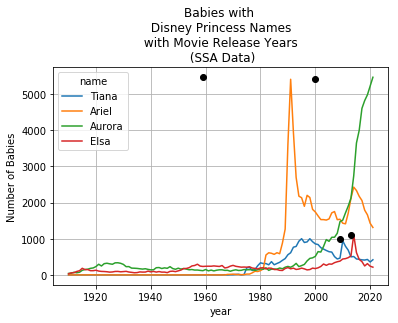

In [11]:
# graphs for post
#print(sns.__version__) #0.8.1
#sns.lineplot(data=df_female_pivot.loc[:, "Tiana"], palette="tab10", linewidth=2.5)

princess_names = ["Tiana", "Ariel", "Aurora", "Elsa"]
movie_years = [2009, 2000, 1959, 2013]

ax = df_female_pivot.loc[:, princess_names].plot(
    title="Babies with \n Disney Princess Names \n with Movie Release Years \n (SSA Data)"
    , grid=True, legend=True)
ax.set_ylabel("Number of Babies")

#note release of corresponding Disney Movie with Name
for pi in range(0, len(princess_names)): 
    plt.plot(movie_years[pi], 
             np.max(df_female_pivot.loc[:, princess_names[pi]]), '+', color='black', marker='o')                 


### (4) **Clustering based on metrics (manually created features) **
The purpose of the features created below are written up in the companion article. 

#### ****Define and find peaks in name popularity****

In [12]:
def plot_peaks(name, x, indexes, algorithm=None, mph=None, mpd=None):
    """Helper function 
    Plot results of the peak dectection.
    Function from https://github.com/MonsieurV/py-findpeaks/blob/master/tests/vector.py"""
    try:
        import matplotlib.pyplot as plt
    except ImportError:
        print('matplotlib is not available.')
        return
    _, ax = plt.subplots(1, 1, figsize=(8, 4))
    ax.plot(x, 'b', lw=1)
    if indexes.size:
        label = 'peak'
        label = label + 's' if indexes.size > 1 else label
        ax.plot(indexes, x[indexes], '+', mfc=None, mec='r', mew=2, ms=8,
                label='%d %s' % (indexes.size, label))
        ax.legend(loc='best', framealpha=.5, numpoints=1)
    ax.set_xlim(-.02*x.size, x.size*1.02-1)
    ymin, ymax = x[np.isfinite(x)].min(), x[np.isfinite(x)].max()
    yrange = ymax - ymin if ymax > ymin else 1
    ax.set_ylim(ymin - 0.1*yrange, ymax + 0.1*yrange)
    ax.set_xlabel('Data #', fontsize=14)
    ax.set_ylabel('Amplitude', fontsize=14)
    ax.set_title('%s %s (mph=%s, mpd=%s)' % (name, algorithm, mph, mpd))
plt.show()

(1) Simple Approach to peak detection 

In [13]:
def peak_detection_simple(trend):
    '''
    simple approach for demonstration
    compute differences between consecutive time periods and count the number of sign changes
    returns the number of sign changes, only if it is from positive to negative 
    '''
    ch = [x1-x0 for x0,x1 in zip(trend,trend[1:]) if x1 != x0]
    return sum([1 if c < 0 else 0 for c in ch])

In [14]:
test_name = "Clarissa"
print('number of sign changes from positive to negative: {}'.format(peak_detection_simple(df_female_pivot['Clarissa'])))

number of sign changes from positive to negative: 58


(2) Peak Detection with Scipy

In [15]:
def get_peaks(df, name, d, verbose=False):
    '''
    Function takes a dataframe, name (string), d (distance of peak)
    Returns index or years of applicable time frames
    '''
    df_filter = df.loc[:, name]
    tvec = np.array(df_filter) 
    indexes, _ = scipy.signal.find_peaks(tvec, height=float(tvec.mean()), distance=d)
    if verbose: 
        print('Peaks are: %s' % (indexes))
        print(tvec[indexes])
    return indexes

Test the peak and helper functions above with sample data. Show trends with plotting data. 

In [16]:
ind = get_peaks(df_female_pivot, test_name, d=5)
print('Print output of indicies with peaks for {}: {}'.format(test_name, ind))
c=0
for i in range(1, len(ind)): 
    if ind[i] - ind[i-1] <= 12: 
        #print(indexes[i] - indexes[i-1])
        c+=1

#calc the range of min and max peaks -- important if within 16 years of each other 
print('Print output of indicies: {}'.format(c))
print('''Is difference between last and first years <= 16 years: {}'''.format(ind[-1] - ind[0] <= 16))

Print output of indicies with peaks for Clarissa: [ 65  78  85  94 100 106]
Print output of indicies: 4
Is difference between last and first years <= 16 years: False


Show plot with peaks marked in the trend with "ind" calculated from sample name

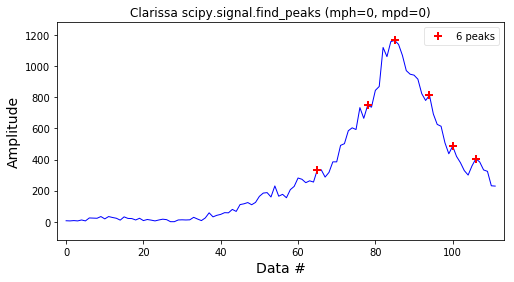

In [17]:
plot_peaks(test_name, 
    np.array(df_female_pivot.loc[:, test_name]),
    ind, mph=0, mpd=0, algorithm='scipy.signal.find_peaks'
)

(4) What are the most recent trend for name? Create feature to calculate year over year growth. 

In [18]:
def yoy_calc(s, df):
    return df.apply(lambda x: (x - x.shift(s)) / x, axis=0)

yoy_female = yoy_calc(1, df_female_pivot)
yoy5_female = yoy_calc(5, df_female_pivot)

(5) What are the top 500 names in the past 3 years? Get list of top 500 years over the past 3 years. We can choose to filter out these names in the final list or create another boolean feature 

In [19]:
#top 500 name within the last 3 years gets filtered out

now = datetime.datetime.now()
last_3_yrs = list(range(now.year - 3,now.year))
count_3_yrs = df_female_pivot.loc[last_3_yrs, :]
df_3_yrs = pd.DataFrame(count_3_yrs.sum().reset_index())
df_3_yrs.columns= ['names', 'count']
df_3_yrs.set_index('names', inplace=True)
df_3_yrs['rank_3yr'] = df_3_yrs.rank(ascending=False)

In [20]:
#let's sample some of the top 500 names 
top_500_list = df_3_yrs[df_3_yrs.loc[:, 'rank_3yr'] <= 500].index
#df_3_yrs[df_3_yrs.loc[:, 'rank_3yr'] <= 500].sort_values('rank_3yr').head(20)


In [21]:
#dataframe of girls name, not including top 500 
df_not_top = df_3_yrs[df_3_yrs.loc[:, 'rank_3yr'] > 500]

#### **Create dataframe with all features discussed above:**

In [22]:
#create fresh dataframe with female names in index
df_metrics = pd.DataFrame(index=list(df_female_pivot.columns))
last_yr = df_female_pivot.index[-1]

In [23]:
#np.array(df_female_pivot.loc[:, 'Ema'])
np.array(df_female_total)

array([ 352089.,  372382.,  504299.,  566973.,  696907.,  908538.,
        965991., 1000434., 1073228., 1047119., 1111873., 1145090.,
       1114106., 1120063., 1161254., 1130296., 1099877., 1106938.,
       1070065., 1035830., 1044635.,  987068.,  988028.,  931728.,
        966799.,  971820.,  963313.,  985468., 1023823., 1017237.,
       1062969., 1125580., 1262866., 1305578., 1239422., 1219604.,
       1475618., 1669257., 1596425., 1608665., 1610015., 1695503.,
       1745309., 1770192., 1828100., 1839586., 1889094., 1924631.,
       1890231., 1900001., 1894713., 1888189., 1835847., 1795151.,
       1760318., 1635312., 1561400., 1517603., 1501613., 1540595.,
       1591380., 1502788., 1362028., 1296494., 1299783., 1285132.,
       1288886., 1348011., 1344515., 1410159., 1462353., 1470101.,
       1494599., 1475838., 1487860., 1518108., 1509765., 1526256.,
       1558725., 1613929., 1657778., 1630171., 1596388., 1559283.,
       1534844., 1507333., 1497491., 1479273., 1497079., 14979

In [24]:
df_female

,year,gender,name,number
0,1910,F,Mary,22848
1,1910,F,Annie,3492
2,1910,F,Anna,6433
3,1910,F,Margaret,8222
4,1910,F,Helen,10479
5,1910,F,Elsie,2123
6,1910,F,Lucy,1263
7,1910,F,Dorothy,7314
8,1911,F,Mary,24390
9,1911,F,Margaret,9279


In [25]:
df_female_pivot

name,Aadhira,Aadhya,Aadya,Aahana,Aahna,Aaima,Aaira,Aairah,Aalani,Aalaya,Aalayah,Aaleah,Aaleyah,Aalia,Aaliah,Aaliya,Aaliyah,Aaliyha,Aalliyah,Aalyah,Aalyiah,Aamani,Aamina,Aaminah,Aamira,Aamirah,Aamiyah,Aamori,Aanchal,Aanika,Aaniya,Aaniyah,Aanshi,Aanvi,Aanya,Aaradhya,Aaralyn,Aaralynn,Aaren,Aaria,...,Zuly,Zuma,Zunaira,Zunairah,Zuni,Zuri,Zuria,Zuriah,Zurie,Zuriel,Zurisadai,Zury,Zuzanna,Zuzu,Zya,Zyah,Zyaira,Zyairah,Zyaire,Zyan,Zyana,Zyanna,Zyanya,Zyasia,Zyeria,Zykeria,Zykeriah,Zykerria,Zykia,Zykierra,Zykira,Zykiria,Zyla,Zylah,Zyon,Zyonna,Zyra,Zyrah,Zyria,Zyriah
year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1910,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1911,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1912,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1913,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1914,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1915,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1916,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1917,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1918,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
for n in df_female_pivot.columns: 
    ipeaks = get_peaks(df_female_pivot, n, d=5)
    #print(n, ipeaks)
    
    if ipeaks.any(): 
    
        #acceleration of names over x years 
        df_metrics.loc[n, "acc_last_1_yr"] = np.mean(yoy_female.loc[(last_yr):, n])
        df_metrics.loc[n, "acc_last_2_yr"] = np.mean(yoy_female.loc[(last_yr-2):, n])
        df_metrics.loc[n, "acc_last_5_yr"] = np.mean(yoy_female.loc[(last_yr-5):, n])
        df_metrics.loc[n, "acc_last_10_yr"] = np.mean(yoy_female.loc[(last_yr-10):, n])
        df_metrics.loc[n, "acc_last_15_yr"] = np.mean(yoy_female.loc[(last_yr-15):, n])
        df_metrics.loc[n, "acc_last_20_yr"] = np.mean(yoy_female.loc[(last_yr-20):, n])
        df_metrics.loc[n, "acc_last_25_yr"] = np.mean(yoy_female.loc[(last_yr-25):, n])

        #acceleration within the last x years
        df_metrics.loc[n, "acc_5_yr"] = np.divide((df_female_pivot.loc[last_yr, n] - df_female_pivot.loc[last_yr -5, n]), df_female_pivot.loc[last_yr -5, n])
        df_metrics.loc[n, "acc_10_yr"] = np.divide((df_female_pivot.loc[last_yr, n] - df_female_pivot.loc[last_yr -10, n]), df_female_pivot.loc[last_yr -10, n])
        df_metrics.loc[n, "acc_15_yr"] = np.divide((df_female_pivot.loc[last_yr, n] - df_female_pivot.loc[last_yr -15, n]), df_female_pivot.loc[last_yr -15, n])
        df_metrics.loc[n, "acc_20_yr"] = np.divide((df_female_pivot.loc[last_yr, n] - df_female_pivot.loc[last_yr -20, n]), df_female_pivot.loc[last_yr -20, n])
        df_metrics.loc[n, "acc_20_yr"] = np.divide((df_female_pivot.loc[last_yr, n] - df_female_pivot.loc[last_yr -25, n]), df_female_pivot.loc[last_yr -25, n])

        #add peaks metrics to the dataframe
        peak_pop = np.array(df_female_pivot.loc[:, n])[ipeaks]
        female_pop = np.array(df_female_total)[ipeaks]
        peaks_since = [len(df_female_pivot.index) - p for p in ipeaks] #how many years since peak? 

        df_metrics.loc[n, "peak_count"] = len(ipeaks)
        df_metrics.loc[n, "peak_recent_years_since"] = min(peaks_since)
        df_metrics.loc[n, "peaks_within_5_years"] = 1 if ipeaks[-1] - ipeaks[0] < 6 else 0

        #calculate avg, min, max, median population at peaks
        pop_perc = list(map(lambda x, y: np.divide(x,y), peak_pop,female_pop))
        df_metrics.loc[n, "peaks_avg_pop_perc"] = np.mean(pop_perc)
        df_metrics.loc[n, "peaks_median_pop_perc"] = np.median(pop_perc)
        df_metrics.loc[n, "peaks_min_pop_perc"] = min(pop_perc)
        df_metrics.loc[n, "peaks_max_pop_perc"] = max(pop_perc)

        #indicators for x years since peaks
        for pp in peaks_since: 
            if pp <= 5: 
                df_metrics.loc[n, "peak_last_5_years"] = 1
            elif pp <= 10: 
                df_metrics.loc[n, "peak_last_10_years"] = 1
            elif pp < 15:
                df_metrics.loc[n, "peak_last_15_years"] = 1
            elif pp < 20: 
                df_metrics.loc[n, "peak_last_20_years"] = 1
            elif pp < 25: 
                df_metrics.loc[n, "peak_last_25_years"] = 1

        #Ever in top y names in the past x years?
        df_metrics['top_3_yrs'] = 1 if n in top_500_list else 0


In [27]:
#check outputs
df_metrics.replace([np.inf, -np.inf], np.nan, inplace=True)
df_metrics.fillna(0, inplace=True)
df_metrics.head()

,acc_last_1_yr,acc_last_2_yr,acc_last_5_yr,acc_last_10_yr,acc_last_15_yr,acc_last_20_yr,acc_last_25_yr,acc_5_yr,acc_10_yr,acc_15_yr,acc_20_yr,peak_count,peak_recent_years_since,peaks_within_5_years,peaks_avg_pop_perc,peaks_median_pop_perc,peaks_min_pop_perc,peaks_max_pop_perc,peak_last_5_years,top_3_yrs,peak_last_10_years,peak_last_15_years,peak_last_20_years,peak_last_25_years
Aadhira,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,4.0,1.0,0.000011,0.000011,0.000011,0.000011,1.0,0,0.0,0.0,0.0,0.0
Aadhya,-0.005405,-0.051981,-0.046971,0.216984,0.000000,0.000000,0.000000,-0.238683,8.250000,0.000000,0.0,1.0,5.0,1.0,0.000183,0.000183,0.000183,0.000183,1.0,0,0.0,0.0,0.0,0.0
Aadya,-0.674699,-0.103604,-0.132012,0.096859,0.000000,0.000000,0.000000,-0.314050,2.608696,10.857143,0.0,2.0,2.0,0.0,0.000098,0.000098,0.000088,0.000107,1.0,0,1.0,0.0,0.0,0.0
Aahana,-0.142857,-0.335454,0.025031,-0.116847,0.041078,0.041078,0.041078,0.500000,0.000000,0.000000,0.0,2.0,4.0,0.0,0.000027,0.000027,0.000020,0.000035,1.0,0,0.0,1.0,0.0,0.0
Aahna,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,8.0,1.0,0.000005,0.000005,0.000005,0.000005,0.0,0,1.0,0.0,0.0,0.0


In [28]:
df_metrics.shape

(21375, 24)

### **(6) Kmeans Clustering**##

Leave Kmeans clustering to partition names into similar groups. Then generate a narrowed list of names from the cluster containting "Pauline."

In [29]:
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

In [30]:
cats = ["peaks_within_5_years", "peak_last_15_years", "peak_last_5_years", "top_3_yrs",
        "peak_last_10_years", "peak_last_25_years", "peak_last_20_years"]
use_cols = [d for d in df_metrics.columns if d not in cats]
x_nums = df_metrics.loc[:, use_cols]
x_scale_num = StandardScaler(copy=True, with_mean=True, with_std=True).fit_transform(x_nums)
df_scale = pd.DataFrame(data=x_scale_num, index=list(df_metrics.index), columns=use_cols)
x_merge = df_scale.join(df_metrics.loc[:, cats])
X = np.array(x_merge.as_matrix())

Run loop to find number of cluster with best silhoutte score 

* A high Silhouette Coefficient value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters. If most objects have a high value, then the clustering configuration is appropriate. If many points have a low or negative value, then the clustering configuration may have too many or too few clusters.

In [31]:
def get_cluster_score(data): 
    for n in range(2, 7): # 11
        kmeans = KMeans(n_clusters=n).fit(data)
        label = kmeans.labels_
        sil_coeff = silhouette_score(data, label, metric='euclidean')
        print("For n_clusters={}, The Silhouette Coefficient is {}".format(n, sil_coeff))

In [32]:
get_cluster_score(X)

For n_clusters=2, The Silhouette Coefficient is 0.8522037007146338
For n_clusters=3, The Silhouette Coefficient is 0.5805484775861406
For n_clusters=4, The Silhouette Coefficient is 0.5976930371015865
For n_clusters=5, The Silhouette Coefficient is 0.20247580135887328
For n_clusters=6, The Silhouette Coefficient is 0.20594141667542878


The best score isn't always the best way to partition the data since the purpose of this exercise is to narrow down the list of names. Clustering the data with 2 distinct groups will yield the best silhoutte score. The next best score is clustering into 4. 

In [33]:
def get_labeled_clusters(c, data, merged,name_ls, desired_name):
    tmp = KMeans(n_clusters=c).fit(data).labels_
    k4 = pd.DataFrame(tmp, index=name_ls, columns=["labels"])
    k4_labels = pd.concat([k4, merged], axis=1)
    print(k4_labels.loc[:, ["labels"]].reset_index().groupby("labels").count())
    print(desired_name, ' is in ', k4_labels.loc[desired_name, "labels"])
    
    return (k4_labels, k4_labels.loc[desired_name, "labels"])

In [34]:
df_r, p_label = get_labeled_clusters(10, X, x_merge, list(df_metrics.index), "Pauline")

        index
labels       
0        4076
1       10979
2         170
3         746
4        4707
5         149
6          21
7           1
8          28
9         498
Pauline  is in  3


In [35]:
#list of names from cluster of desired name
r = list(df_r[df_r.labels==p_label].index)
print(r)
df_r[df_r.labels==p_label].to_csv("baby_names_metrics_cluster.csv")

['Aaleyah', 'Aaradhya', 'Abbey', 'Abbie', 'Abbigail', 'Abbygail', 'Abella', 'Abigael', 'Abrianna', 'Abygail', 'Acacia', 'Adah', 'Adalind', 'Adalyne', 'Adalynne', 'Adamari', 'Adamaris', 'Addelynn', 'Adelle', 'Adilyn', 'Aditi', 'Adria', 'Adrian', 'Adrianne', 'Aicha', 'Aiko', 'Aime', 'Ainslee', 'Airam', 'Aislyn', 'Aja', 'Alanis', 'Alaynah', 'Alea', 'Aleeah', 'Aleeyah', 'Aleigha', 'Alexa', 'Alexandrea', 'Alexi', 'Alexia', 'Ali', 'Alinah', 'Aline', 'Alissa', 'Aliyanna', 'Allana', 'Allegra', 'Allisson', 'Alona', 'Alycia', 'Alyse', 'Alysha', 'Alyza', 'Amairani', 'Amaiya', 'Amariana', 'Amariyah', 'Amayrani', 'America', 'Amna', 'Amoni', 'Amya', 'Amyah', 'An', 'Anabel', 'Anabelle', 'Analeigh', 'Analicia', 'Analisa', 'Anamaria', 'Anessa', 'Angeli', 'Angelie', 'Angelita', 'Aniah', 'Anisha', 'Aniyla', 'Anja', 'Anjali', 'Annalynn', 'Annalyse', 'Annamarie', 'Annemarie', 'Annmarie', 'Anny', 'Aralynn', 'Arisha', 'Arissa', 'Ariyana', 'Ariyanna', 'Arleen', 'Arlyn', 'Aruna', 'Aryanna', 'Ashanti', 'Ashlee'

Text(0,0.5,'Number of Babies')

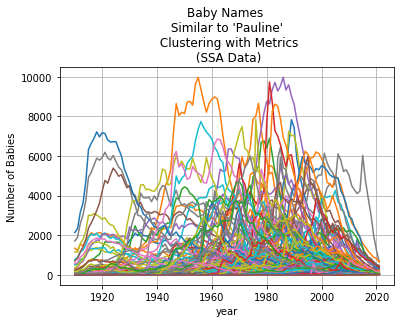

In [36]:
ax = df_female_pivot.loc[:, r].plot(
    title="Baby Names \n Similar to 'Pauline' \n Clustering with Metrics\n (SSA Data)"
    , grid=True, legend=False)
ax.set_ylabel("Number of Babies")


***Principle Component Analysis and Clustering***

In [37]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [38]:
tmp = df_female.pivot(index='name', columns='year', values='number')
tmp.fillna(0, inplace=True)
tmp.shape

(21375, 112)

In [39]:
sc = StandardScaler()
X_pca_name_ls = list(tmp.index)
X_pca = np.array(sc.fit_transform(tmp))
X_pca.shape

(21375, 112)

Determine the number of components that explain at least 85% of the variance in the data. In supervised learning, we could test the number of components to be modeled with target variable. The plot of PCA cumulative variance explained by number of components shows that 4 components will explain 88% of the variance. 

[0.41771934 0.64987285 0.79330159 0.87884863 0.92681664 0.95094759
 0.96646028 0.97642091 0.98209456 0.98626717 0.98901628 0.99124941
 0.99259332 0.9937612  0.99466156 0.99532897 0.99592694 0.99643225
 0.99680374 0.99711925 0.9973957  0.99765636 0.99786837 0.99803133
 0.99815816]


Text(0.5,1,'Name Trends PCA')

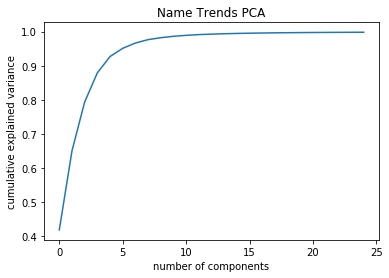

In [40]:
pca_check = PCA(n_components=25)
pca_check.fit(X_pca)
print(np.cumsum(pca_check.explained_variance_ratio_))

plt.plot(np.cumsum(pca_check.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title('Name Trends PCA')

Select the number of PCA components desired based on what we learned above. We can always choose more than 4 components. Remember less is more! 

In [41]:
pca = PCA(n_components=10)
X_pca_transform = pca.fit_transform(X_pca)
X_pca_transform.shape

(21375, 10)

When we use PCA components to partition the names. Any number of clusters between 2 to 10 yields about teh same silhouette score. Let's see how the names are grouped by using both 4 and 10 clusters. I prefer 10 clusters if I can get a shorter list! 

In [42]:
get_cluster_score(X_pca_transform)

For n_clusters=2, The Silhouette Coefficient is 0.9775774483995857
For n_clusters=3, The Silhouette Coefficient is 0.9781028188712383
For n_clusters=4, The Silhouette Coefficient is 0.9775842267298387
For n_clusters=5, The Silhouette Coefficient is 0.9645416976760415
For n_clusters=6, The Silhouette Coefficient is 0.9650714139769563


In [43]:
#get_labeled_clusters(4, X_pca_transform, df_female, X_pca_name_ls, "Pauline")
tmp = KMeans(n_clusters=10).fit(X_pca_transform).labels_
data_components = pd.DataFrame(X_pca_transform, index=X_pca_name_ls)
data_components['labels'] = tmp
data_components.head()
print(data_components.loc[:, ["labels"]].reset_index().groupby("labels").count())

        index
labels       
0       20976
1          17
2          23
3           1
4          16
5         184
6          66
7           5
8          13
9          74


In [44]:
p_label2 = data_components.loc["Pauline", "labels"]
print(p_label2)

6


In [45]:
#list of names from cluster 2
r2 = list(data_components[data_components.labels==p_label2].index)
print(r2)
data_components[data_components.labels==p_label2].to_csv("baby_names_metrics_cluster.csv")

['Alice', 'Ann', 'Anna', 'Anne', 'Annie', 'Beatrice', 'Bernice', 'Bertha', 'Beverly', 'Bonnie', 'Carolyn', 'Catherine', 'Clara', 'Dolores', 'Doris', 'Edith', 'Edna', 'Elaine', 'Eleanor', 'Ellen', 'Elsie', 'Esther', 'Ethel', 'Evelyn', 'Florence', 'Frances', 'Geraldine', 'Gertrude', 'Gladys', 'Gloria', 'Hazel', 'Irene', 'Jane', 'Janet', 'Janice', 'Jean', 'Joan', 'Josephine', 'Joyce', 'Juanita', 'Judith', 'Judy', 'June', 'Lillian', 'Lois', 'Lorraine', 'Louise', 'Lucille', 'Marie', 'Marilyn', 'Marion', 'Marjorie', 'Martha', 'Mildred', 'Norma', 'Pauline', 'Peggy', 'Phyllis', 'Rita', 'Rose', 'Ruby', 'Shirley', 'Sylvia', 'Thelma', 'Virginia', 'Wanda']


Text(0,0.5,'Number of Babies')

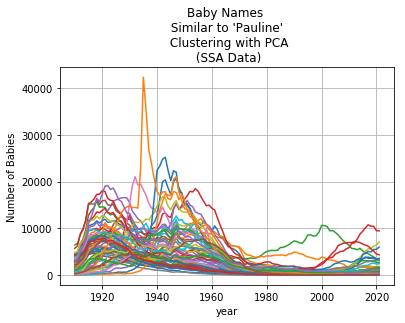

In [46]:
ax = df_female_pivot.loc[:, r2].plot(
    title="Baby Names \n Similar to 'Pauline' \n Clustering with PCA\n (SSA Data)"
    , grid=True, legend=False)
ax.set_ylabel("Number of Babies")

Combined PCA and manual feature lists to get results of names

In [47]:
# combine X_pca_transform and X for cluster analysis
# number of clusters 
X_combo = np.concatenate((X,X_pca_transform),axis=1)
get_cluster_score(X_combo)

For n_clusters=2, The Silhouette Coefficient is 0.9502670490165894
For n_clusters=3, The Silhouette Coefficient is 0.9501107140966868
For n_clusters=4, The Silhouette Coefficient is 0.9493588162089767
For n_clusters=5, The Silhouette Coefficient is 0.9093532744605892
For n_clusters=6, The Silhouette Coefficient is 0.907632638308312


In [48]:
data_combo, p_label3 = get_labeled_clusters(6, X_combo, df_female, X_pca_name_ls, "Pauline")

        index
labels       
0.0     21149
1.0        27
2.0        48
3.0         1
4.0        27
5.0       123
Pauline  is in  2.0


In [49]:
r3 = list(data_components[data_components.labels==p_label3].index)
print(r3)
data_combo[data_combo.labels==p_label3].to_csv("baby_names_combo_cluster.csv")

['Alexandra', 'Alexis', 'Allison', 'Alyssa', 'Amber', 'Ashley', 'Brianna', 'Brittany', 'Courtney', 'Danielle', 'Emily', 'Hannah', 'Jasmine', 'Katherine', 'Kayla', 'Lauren', 'Megan', 'Morgan', 'Natalie', 'Rachel', 'Samantha', 'Taylor', 'Victoria']


Text(0,0.5,'Number of Babies')

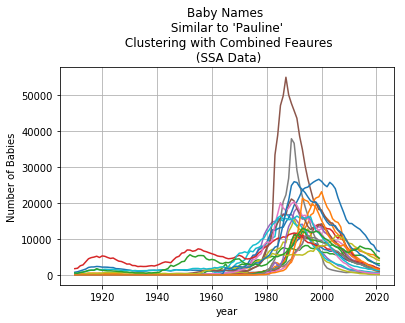

In [50]:
ax = df_female_pivot.loc[:, r3].plot(
    title="Baby Names \n Similar to 'Pauline' \n Clustering with Combined Feaures\n (SSA Data)"
    , grid=True, legend=False)
ax.set_ylabel("Number of Babies")

What names are in both lists?

In [51]:
both = set(r).intersection(set(r2))
print(both)
print(len(both))

{'Juanita', 'Bernice', 'Pauline'}
3


In [52]:
set(r).intersection(set(r3))

set()

In [53]:
print(len(r))
print(len(r2))

746
66
